# Graphical Analysis of Structured Experiment Data

Visualizes analysis metrics from CSVs in `data/structured_analysis/` using `src/graphical_analysis` utilities.

- Exemplary single-experiment trajectories with all metrics overlayed.
- Aggregated similarity trajectories across experiments with 95% CIs.



In [5]:
# Setup
import sys
from pathlib import Path

sys.path.append("src")

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graphical_analysis import (
    ANALYSIS_METRICS,
    list_experiment_csvs,
    load_experiment_rows,
    merge_metric_across_experiments,
    aggregate_metric_across_experiments,
)

sns.set_theme(style="whitegrid")

DATA_ROOT = Path("../data/structured_analysis")
assert DATA_ROOT.exists(), f"Missing data dir: {DATA_ROOT}"

csv_paths = list_experiment_csvs(str(DATA_ROOT))
print(f"Found {len(csv_paths)} experiment CSVs")
assert csv_paths, "No experiment CSVs found in data/structured_analysis"


Found 145 experiment CSVs


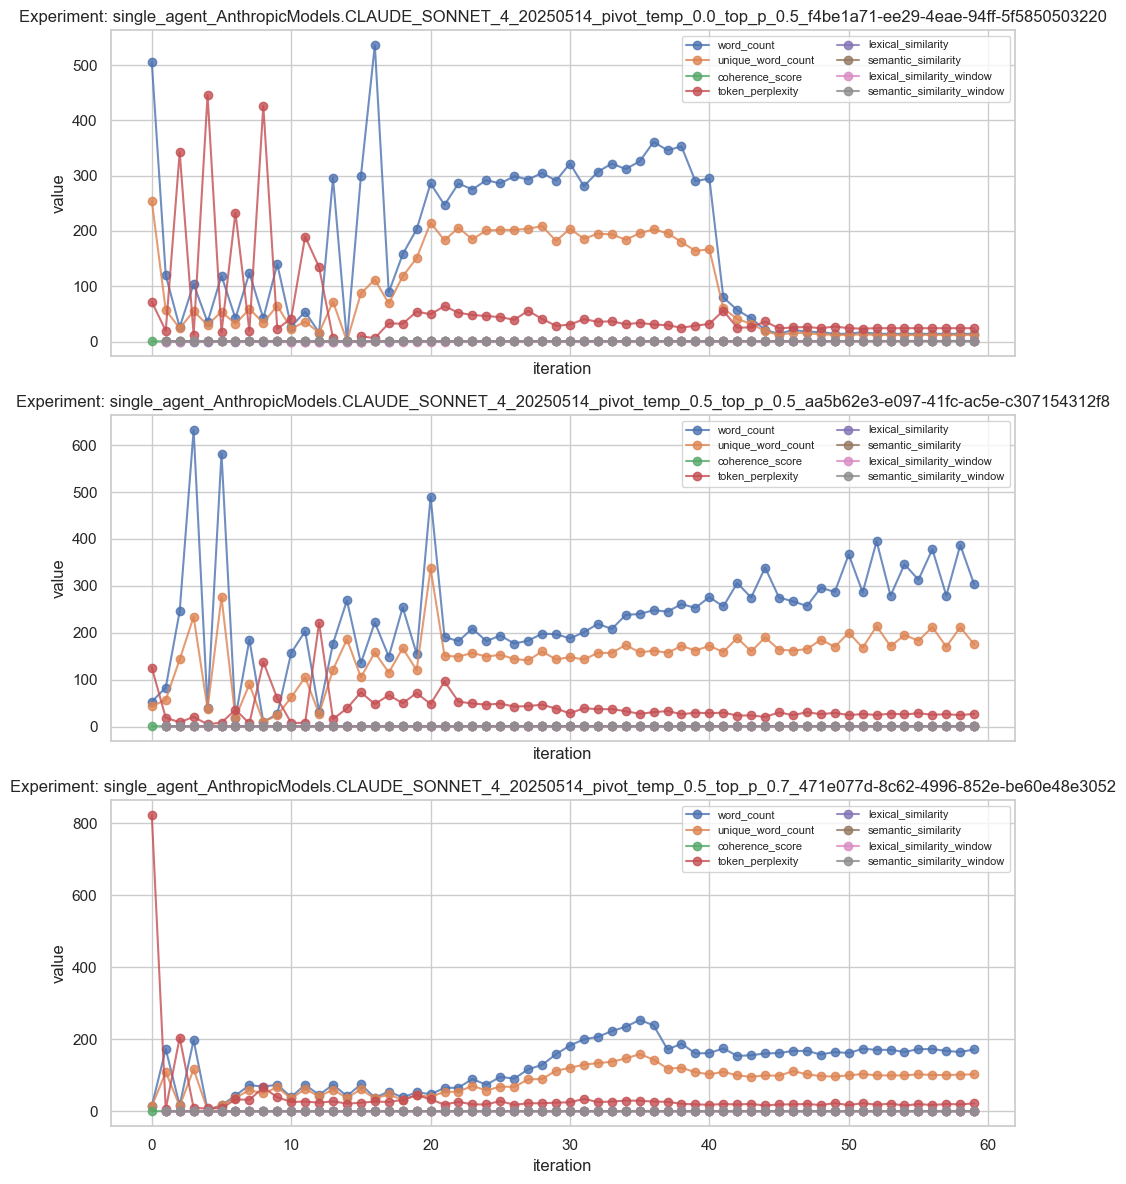

In [6]:
# Exemplary single-experiment trajectories with all metrics overlayed
MAX_EXPERIMENTS = 3
exp_to_rows = {}

for p in csv_paths[:MAX_EXPERIMENTS]:
    rows = load_experiment_rows(p)
    if not rows:
        continue
    exp_name = Path(p).parent.name
    exp_to_rows[exp_name] = rows

num_plots = len(exp_to_rows)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots), sharex=True)
if num_plots == 1:
    axes = [axes]

for ax, (exp, rows) in zip(axes, exp_to_rows.items()):
    df = pd.DataFrame([r.__dict__ for r in rows])
    it = df["iteration"].to_numpy()

    for metric in ANALYSIS_METRICS:
        if metric not in df.columns:
            continue
        vals = df[metric].astype(float).to_numpy()
        if np.all(np.isnan(vals)):
            continue
        ax.plot(it, vals, marker="o", label=metric, alpha=0.8)

    ax.set_title(f"Experiment: {exp}")
    ax.set_xlabel("iteration")
    ax.set_ylabel("value")
    ax.legend(loc="best", ncols=2, fontsize=8)

plt.tight_layout()
plt.show()


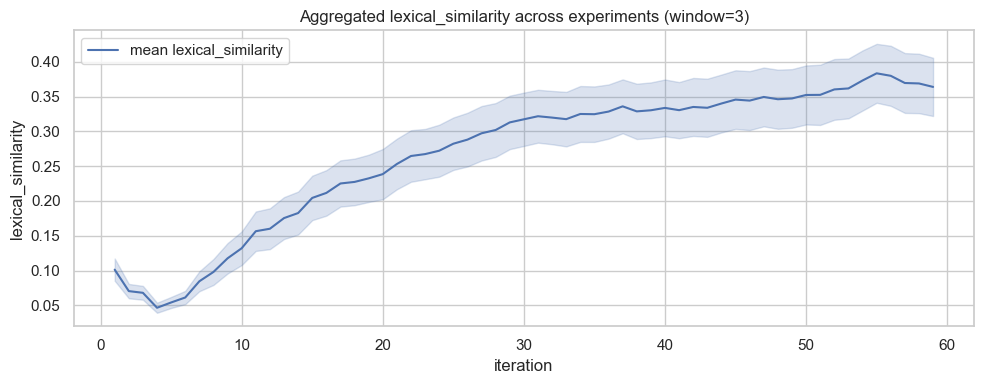

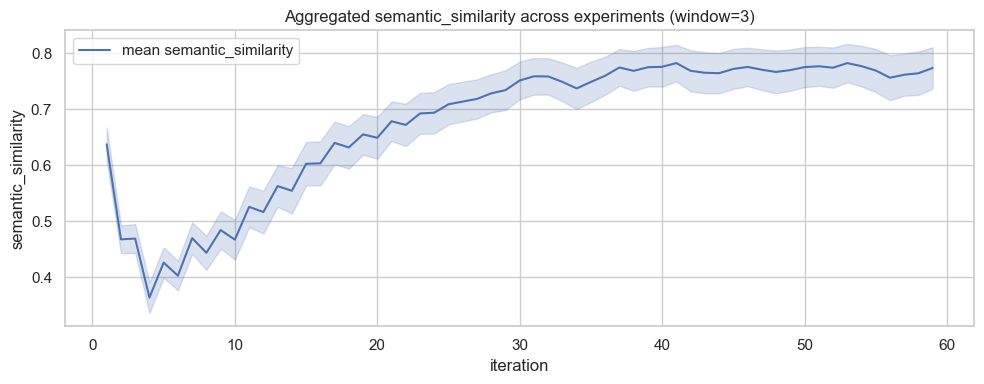

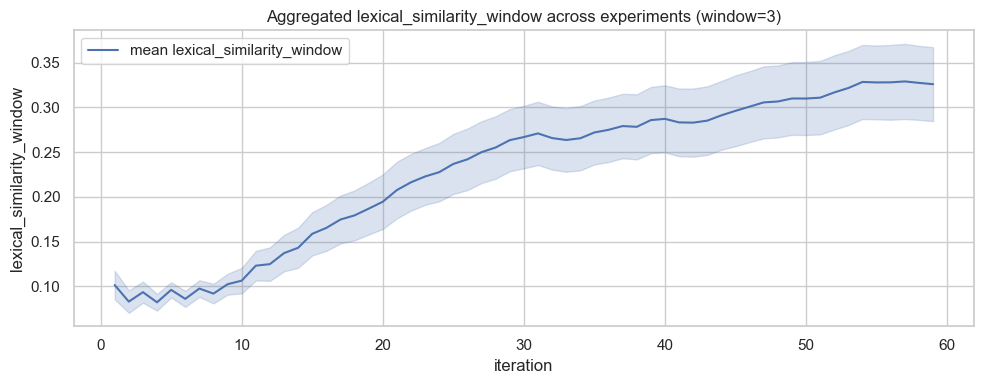

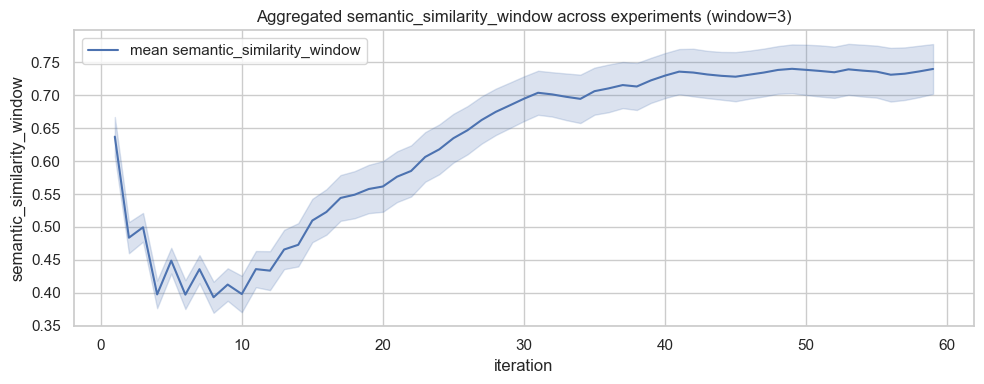

In [7]:
# Aggregated similarity trajectories with uncertainty intervals
SIMILARITY_METRICS = [
    "lexical_similarity",
    "semantic_similarity",
    "lexical_similarity_window",
    "semantic_similarity_window",
]

WINDOW = 3

for metric in SIMILARITY_METRICS:
    merged = merge_metric_across_experiments(csv_paths, metric)
    if merged.empty:
        print(f"No data for metric: {metric}")
        continue
    agg = aggregate_metric_across_experiments(merged, window=WINDOW)

    plt.figure(figsize=(10, 4))
    plt.plot(agg["iteration"], agg["mean"], color="C0", label=f"mean {metric}")
    plt.fill_between(
        agg["iteration"], agg["ci_low"], agg["ci_high"], color="C0", alpha=0.2
    )
    plt.title(f"Aggregated {metric} across experiments (window={WINDOW})")
    plt.xlabel("iteration")
    plt.ylabel(metric)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
